In [1]:
import pandas as pd
import os
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import pickle
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



## Cargamos dataset

In [2]:
ds = pd.read_csv('./musk.data', header = None)
# Quitamos las dos primeras columnas ya que son nombres simbólicos
ds = ds.drop([0,1], axis=1)

In [3]:
ds.columns -= 2

In [4]:
output = ds.shape[1]-1 # Columna de output
y = ds[output].values
X = ds.drop(output,axis=1).values
seed = 42
random.seed(seed)
np.random.seed(seed)

## Preprocesado de datos

**Comprobamos que no haya "missing values"**  
Según https://archive.ics.uci.edu/ml/datasets, no tiene Missing Values.

**Comprobamos que no haya variables con "near-zero variance"**  
Vemos que no hay ninguna.

In [5]:
# No sé si está bien
ds.columns[ds.std() < 0.001]

Int64Index([], dtype='int64')

**Comprobamos que las clases no estén desbalanceadas**  
Están un poco desbalanceadas.

In [6]:
print('Proporción clase 0: ',np.mean(y==0))
print('Proporción clase 1: ',np.mean(y==1))

Proporción clase 0:  0.8458623825401637
Proporción clase 1:  0.1541376174598363


**Estandarizamos los datos**

In [7]:
X = (X - np.mean(X)) / np.std(X)

**Desordenamos los datos**

In [8]:
X,y = shuffle(X,y)

## Entrenamiento de Modelos

**kFold - Decision Tree Classifier**

In [9]:
%%time
kf = KFold(n_splits=10,shuffle=True)
resultados_train = []
resultados_test = []
model = []
res_train = np.empty((30,0))
res_test = np.empty((30,0))
train_indices = []
test_indices = []
etiquetas = ['DT Normal',
             'DT Profundidad',
             'DT Minimo de muestras por hoja',
             'DT Minimo de muestras en subarbol',
             'DT Minimo de impureza',
             'LDA lsqr',
             'LDA eigen',
             'LDA svd',
             'QDA']
dicc = [{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.0},
        {'max_depth': 5,    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.0},
        {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_impurity_decrease': 0.0},
        {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_impurity_decrease': 0.0},
        {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.2}]

for i in range(len(dicc)):
    train_indices2 = []
    test_indices2 = []
    for j in range(3):
        for train_index, test_index in kf.split(X):
            X_train, X_test, y_train, y_test = X[train_index],X[test_index],y[train_index],y[test_index]
            train_indices2.append(train_index)
            test_indices2.append(test_index)
            alg = DecisionTreeClassifier(**dicc[i])
            alg.fit(X_train, y_train)
            model.append(alg)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_test.append(alg.score(X_test, y_test))
    res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
    res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
    resultados_train = []
    resultados_test = []
    train_indices.append(train_indices2)
    test_indices.append(test_indices2)

Wall time: 1min 2s


**kFold - Linear Discriminant Analysis**

In [10]:
%%time
for tipo in ('lsqr', 'eigen', 'svd'):
    train_indices2 = []
    test_indices2 = []
    for _ in range(3):
        for train_index, test_index in kf.split(X):
            X_train, X_test, y_train, y_test = X[train_index],X[test_index],y[train_index],y[test_index]
            alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
            train_indices2.append(train_index)
            test_indices2.append(test_index)
            alg.fit(X_train, y_train)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_test.append(alg.score(X_test, y_test))
    res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
    res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
    resultados_train = []
    resultados_test = []
    train_indices.append(train_indices2)
    test_indices.append(test_indices2)

Wall time: 18.3 s


**kFold - Quadratic Discriminant Analysis**

In [11]:
%%time
train_indices2 = []
test_indices2 = []
for _ in range(3):
    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X[train_index],X[test_index],y[train_index],y[test_index]
        train_indices2.append(train_index)
        test_indices2.append(test_index)
        alg = QuadraticDiscriminantAnalysis()
        alg.fit(X_train, y_train)
        resultados_train.append(alg.score(X_train, y_train))
        resultados_test.append(alg.score(X_test, y_test))
res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
resultados_train = []
resultados_test = []
train_indices.append(train_indices2)
test_indices.append(test_indices2)

Wall time: 6.19 s


**kFold - Support Vector Classification**

In [12]:
%%time
etiquetas.extend(['SVM poly 2º C1',
             'SVM poly 3º C1',
             'SVM poly 4º C1',
             'SVM rfb auto C1',
             'SVM rfb 0.05 C1',
             'SVM rfb 0.1 C1',
             'SVM rfb 0.2 C1'])
# etiquetas.extend(['SVM linear C100',
#              'SVM poly 2º C100',
#              'SVM poly 3º C100',
#              'SVM poly 4º C100',
#              'SVM rfb auto C100',
#              'SVM rfb 0.05 C100',
#              'SVM rfb 0.1 C100',
#              'SVM rfb 0.2 C100'])
dicc = [{'C': 1.0, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto', 'class_weight': 'balanced'},
        {'C': 1.0, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 'class_weight': 'balanced'},
        {'C': 1.0, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto', 'class_weight': 'balanced'},
        {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'class_weight': 'balanced'},
        {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.05, 'class_weight': 'balanced'},
        {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.1, 'class_weight': 'balanced'},
        {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.2, 'class_weight': 'balanced'}]

for i in range(len(dicc)):
    train_indices2 = []
    test_indices2 = []
    for j in range(3):
        for train_index, test_index in kf.split(X):
            X_train, X_test, y_train, y_test = X[train_index],X[test_index],y[train_index],y[test_index]
            train_indices2.append(train_index)
            test_indices2.append(test_index)
            alg = SVC(**dicc[i])
            alg.fit(X_train, y_train)
            model.append(alg)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_test.append(alg.score(X_test, y_test))
    res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
    res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
    resultados_train = []
    resultados_test = []
    train_indices.append(train_indices2)
    test_indices.append(test_indices2)

Wall time: 27min 26s


**Persistencia**

In [13]:
with open('p3_musk-res_test.bin','wb') as file:
    pickle.dump(res_test, file)
with open('p3_musk-train_indices.bin','wb') as file:
    pickle.dump(train_indices, file)
with open('p3_musk-test_indices.bin','wb') as file:
    pickle.dump(test_indices, file)
with open('p3_musk-models.bin','wb') as file:
    pickle.dump(model, file)

In [ ]:
# with open('p3_musk-res_test.bin','rb') as file:
#     res_test = pickle.load(file)
# with open('p3_musk-train_indices.bin','wb') as file:
#     train_indices = pickle.load(file)
# with open('p3_musk-test_indices.bin','wb') as file:
#     test_indices = pickle.load(file)
# with open('p3_musk-models.bin','wb') as file:
#     model = pickle.load(file)

**Test de normalidad**  
Rechazamos normalidad, podriamos asumir normalidad en alguno de ellos pero como en algunos no, realizamos el test no paramétrico de Kruskal-Wallis en lugar de un Anova 

In [14]:
np.apply_along_axis(lambda x: stats.shapiro(x)[1], axis=0, arr=res_test)

array([0.64178133, 0.35693455, 0.23727435, 0.40689668, 0.82497764,
       0.4319551 , 0.13094494, 0.52816641, 0.69267547, 0.27053005,
       0.71522981, 0.12687281, 0.91785985, 0.48702827, 0.06312744,
       0.27974397])

**Test de Kruskal-Wallis**  
Rechazamos que las precisiones sean similares

In [15]:
print(stats.kruskal(*zip(*list(res_test))))

KruskalResult(statistic=413.8425126134252, pvalue=8.504178075377961e-79)


In [16]:
labels = [etiquetas[i] for i in range(res_test.shape[1]) for _ in range(res_test.shape[0])]
arr_test = res_test.flatten('F')
resultados = pairwise_tukeyhsd(arr_test,labels)
# resultados.summary()

In [17]:
#seleccionamos el que tiene mejor media y vemos en el anterior cuales son iguales
best_group = np.argmax(np.mean(res_test, axis = 0))
best_group = etiquetas[int(best_group)]

Figure(720x432)


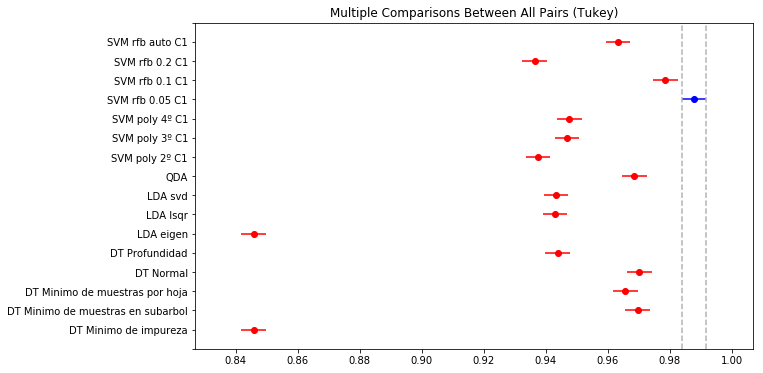

In [18]:
print(resultados.plot_simultaneous(comparison_name=best_group))

In [19]:
resultados = resultados._results_table.data

In [28]:
group1 = resultados[0].index('group1')
group2 = resultados[0].index('group2')
reject = resultados[0].index('reject')
best_groups = []
for row in resultados[1:]:
    if (row[group1] == str(best_group) or row[group2] == str(best_group)) and not row[reject]:
        best_groups.append(row[group1])
        best_groups.append(row[group2])
best_groups.append(best_group)
best_groups = set(best_groups)
sorted(best_groups)

['SVM rfb 0.05 C1']

**Nos quedamos con el más sencillo**  
El cual asumimos que es el Lineal Discriminant Analysis con lsqr (Minimos cuadrados)

In [21]:
# def performance_indexes(CM, PositiveClass):
#     classNum = len(CM)
#     TP = CM[PositiveClass, PositiveClass]
#     TN = 0
#     FP = 0
#     FN = 0
#     for real in range(classNum):
#         for predicted in range(classNum):
#             if (real != PositiveClass and predicted != PositiveClass):
#                 TN += CM[real, predicted]
#             if (real != PositiveClass and predicted == PositiveClass):
#                 FP += CM[real, predicted]
#             if (real == PositiveClass and predicted != PositiveClass):
#                 FN += CM[real, predicted]
#     Sens = TP/(TP+FN)
#     Spec = TN/(TN+FP)
#     PPV = TP/(TP+FP)
#     NPV = TN/(TN+FN)
#     ACC = (TP+TN)/(TP+TN+FP+FN)
#     return Sens,Spec,PPV,NPV,ACC

In [22]:
# # Escogemos el modelo más simple de entre los mejores
# simple = etiquetas.index('LDA svd')
# tipo = 'svd'
# Sens_l = []
# Spec_l = []
# PPV_l = []
# NPV_l = []
# ACC_l = []
# for test_index in test_indices[simple]:
#     train_index = np.ones(y.shape, dtype=bool)
#     train_index[test_index] = False
#     X_test, y_test = X[test_index], y[test_index]
#     X_train, y_train = X[train_index], y[train_index]
#     alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
#     alg.fit(X_train, y_train)
#     y_pred = alg.predict(X_test)
#     CM = confusion_matrix(y_test, y_pred)
#     Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,1)
#     Sens_l.append(Sens)
#     Spec_l.append(Spec)
#     PPV_l.append(PPV)
#     NPV_l.append(NPV)
#     ACC_l.append(ACC)
# print(('Sens: {:.2f}, Spec: {:.2f}, ' +
#        'PPV: {:.2f}, NPV: {:.2f}, ACC: {:.2f}').format(np.mean(Sens_l),
#                                                        np.mean(Spec_l),
#                                                        np.mean(PPV_l),
#                                                        np.mean(NPV_l),
#                                                        np.mean(ACC_l)))


Sens: 0.73, Spec: 0.98, PPV: 0.89, NPV: 0.95, ACC: 0.94


**----------------------------------------------------------------------------------------------------------------------------**

In [24]:
for ind, tag in enumerate(etiquetas):
    mean_test = np.mean(res_test[:,ind])
    std_test = np.std(res_test[:,ind])
    print('{}: {:.2f} +- {:.2f}'.format(tag, mean_test, std_test))

DT Normal: 0.97 +- 0.01
DT Profundidad: 0.94 +- 0.01
DT Minimo de muestras por hoja: 0.97 +- 0.01
DT Minimo de muestras en subarbol: 0.97 +- 0.01
DT Minimo de impureza: 0.85 +- 0.01
LDA lsqr: 0.94 +- 0.01
LDA eigen: 0.85 +- 0.01
LDA svd: 0.94 +- 0.01
QDA: 0.97 +- 0.01
SVM poly 2º C1: 0.94 +- 0.01
SVM poly 3º C1: 0.95 +- 0.01
SVM poly 4º C1: 0.95 +- 0.01
SVM rfb auto C1: 0.96 +- 0.01
SVM rfb 0.05 C1: 0.99 +- 0.00
SVM rfb 0.1 C1: 0.98 +- 0.01
SVM rfb 0.2 C1: 0.94 +- 0.01


In [ ]:
# # Prueba con SVM poly 2º
# simple = etiquetas.index('SVM poly 2º C1')
# dicc = [{'C': 1.0, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto', 'class_weight': 'balanced'}]
# Sens_l = []
# Spec_l = []
# PPV_l = []
# NPV_l = []
# ACC_l = []
# for test_index in test_indices[simple]:
#     train_index = np.ones(y.shape, dtype=bool)
#     train_index[test_index] = False
#     X_test, y_test = X[test_index], y[test_index]
#     X_train, y_train = X[train_index], y[train_index]
#     alg = SVC(**dicc[0])
#     alg.fit(X_train, y_train)
#     y_pred = alg.predict(X_test)
#     CM = confusion_matrix(y_test, y_pred)
#     Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,1)
#     Sens_l.append(Sens)
#     Spec_l.append(Spec)
#     PPV_l.append(PPV)
#     NPV_l.append(NPV)
#     ACC_l.append(ACC)
# print(('Sens: {:.2f}, Spec: {:.2f}, ' +
#        'PPV: {:.2f}, NPV: {:.2f}, ACC: {:.2f}').format(np.mean(Sens_l),
#                                                        np.mean(Spec_l),
#                                                        np.mean(PPV_l),
#                                                        np.mean(NPV_l),
#                                                        np.mean(ACC_l)))

## Persistencia

In [ ]:
# with open('RForest_Zika_oversampled.bin','wb') as file:
#     pickle.dump(alg_o, file)
# with open('RForest_Zika_undersampled.bin','wb') as file:
#     pickle.dump(alg_u, file)

## FIN